# Feature Engineering and Classification of Disaster Images

In [ ]:
import os
# temporarily set this environment variable to avoid issues with duplicate libraries
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

home = os.path.expanduser("~")
this_dir = os.path.join(home, "SURE-2025")
os.chdir(this_dir) # ensure we are in the correct directory

## Data

In this project, we are using the CrisisMMD dataset. There are several advantages of using CrisisMMD. 
#### Advantages
* each tweet has at least one image associated with it, so we can train text and image models that work on the same distribution
* ***continue later***

But there are some disadvantages worth mentioning as well. 
#### Disadvantages
* the humanitarian classes we use here are highly imbalanced
* images and tweets can have different labels, which can complicate classification

We can begin visualizing the data by placing it into a pandas DataFrame. After, we will place it in a custom Pytorch Dataset. 

**Note**: after downloading CrisisMMD v2, I placed it directly in my user folder for the most direct access. 

In [2]:
from pathlib import Path
import os
import pandas as pd

# access the data from the folders
home = Path(os.path.expanduser('~'))
dir = home / 'CrisisMMD_v2.0' / 'CrisisMMD_v2.0' 
datasplit_dir = dir / 'crisismmd_datasplit_all' / 'crisismmd_datasplit_all'
train_data = pd.read_csv(datasplit_dir / 'task_humanitarian_text_img_train.tsv', sep='\t')

In [3]:
train_data.head(3)

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,california_wildfires,917791291823591425,917791291823591425_1,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,not_humanitarian,other_relevant_information,not_humanitarian,Negative
1,california_wildfires,917791291823591425,917791291823591425_0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,other_relevant_information,other_relevant_information,infrastructure_and_utility_damage,Negative
2,california_wildfires,917793137925459968,917793137925459968_0,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive


In [4]:
train_data['label_image'].value_counts()

label_image
not_humanitarian                          6565
infrastructure_and_utility_damage         2761
other_relevant_information                1860
rescue_volunteering_or_donation_effort    1694
affected_individuals                       397
vehicle_damage                             230
injured_or_dead_people                      92
missing_or_found_people                      9
Name: count, dtype: int64

Now that we know what the data looks like, we can visualize the images by accessing the paths in the DataFrame. (*Warning*: the dataset contains some sensitive images)

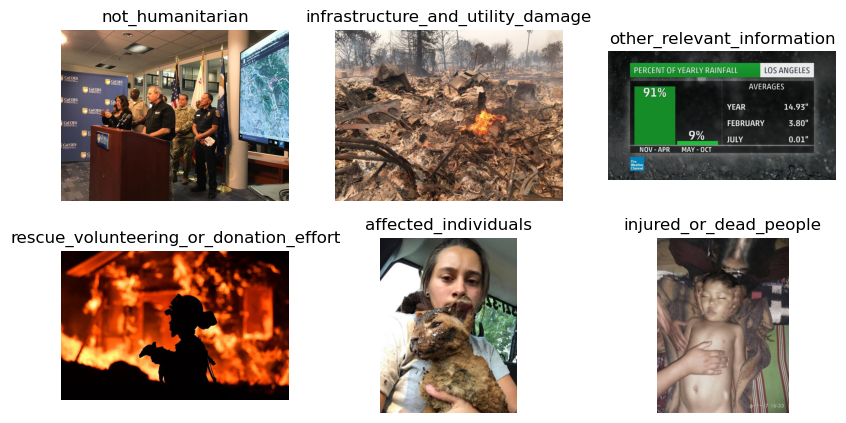

In [ ]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# Visualize 6 images from the training set of the classes we are interested in
classes = [label for label in 
               train_data['label_image'].value_counts().reset_index()['label_image'].to_dict().values()
               if label not in ['vehicle_damage', 'missing_or_found_people']]

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
# i goes 0 through 5
for i, label in enumerate(classes):
    ax = axes[i // 3, i % 3]
    img_path = train_data[train_data['label_image'] == label].iloc[0]['image']
    img = Image.open(dir / img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
plt.show()

## Feature Engineering - Traditional Features

We will want to see how several different combinations of transformations affect the images. Those transformations are Gabor filters, Hu Moments, color histograms, and local binary patterns. These are considered traditional image feature-engineering techniques. The goal with applying the transformations is to promote intra-class similarity and inter-class variance. 

### Gabor filters

Gabor filters are meant to mimic the way that humans see images. They are commonly used for feature discrimination, texture analysis, and edge detection. They represent a Gaussian envelope modified by a sinusoidal function. They have been shown to have good results on complex tasks, such as facial images.

In [58]:
import numpy as np
from scipy import ndimage as ndi

from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from skimage.color import rgb2gray

# TODO: learn more about optimal params and features to extract 
# computes features that can be input to a classifier
def compute_gabor_feats(image, kernels):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for i, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[i, 0] = filtered.mean()
        feats[i, 1] = filtered.var() # computes variance for flattened array
        feats[i, 3] = np.linalg.norm(filtered) # computes the L2 norm/magnitude of the filtered image
        feats[i, 2] = filtered.std()
    return feats

# for convolving the gabor kernel with the images to see response
# input is a ndarray image and a kernel
def power(image, kernel):
    # Normalize (and convert to greyscale) images for better comparison.
    # The range of a floating point image is [0.0, 1.0] or [-1.0, 1.0] 
    image = img_as_float(rgb2gray(image))
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(input=image, weights=np.real(kernel), mode='wrap') **2
        + ndi.convolve(image, np.imag(kernel), mode='wrap') ** 2)*255



kernels = []
for theta in range(4):
    theta = theta / 4.0 * np.pi 
    for sigma in (1,3):
        for freq in (0.05,.25):
            kernel = np.real(
                gabor_kernel(freq, theta=theta, sigma_x=sigma, sigma_y=sigma)
            )
            kernels.append(kernel)

for kernel in kernels:
    print(kernel.shape)

(7, 7)
(7, 7)
(19, 19)
(19, 19)
(7, 7)
(7, 7)
(15, 15)
(15, 15)
(7, 7)
(7, 7)
(19, 19)
(19, 19)
(7, 7)
(7, 7)
(15, 15)
(15, 15)


In [7]:
shrink = (slice(0, None, 3), slice(0, None, 3)) # to shrink image size before using the kernel
imgs_ = []
for i, label in enumerate(classes):
    img_path = train_data[train_data['label_image'] == label].iloc[0]['image']
    img = Image.open(dir / img_path)
    
    img = img_as_float(np.array(img)[shrink])
    imgs_.append(img)


powers = []
for img in imgs_:
    for kernel in kernels:
        powers.append(power(img, kernel))


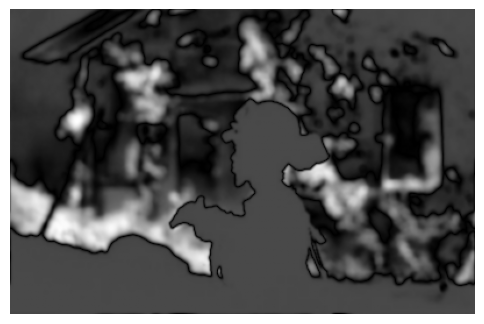

In [36]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.set_axis_off()
ax.imshow(powers[48], cmap='grey')

In [59]:
import cv2 

label = classes[3] # rescue, volunteer, or donation

image = train_data[train_data['label_image'] == label].iloc[0]['image']

image = cv2.normalize(rgb2gray(np.array(Image.open(dir / image))), None, 0, 1, cv2.NORM_MINMAX)

feats = compute_gabor_feats(image, kernels)

# feats describing mean, variance, magnitude, and standard deviation of the filtered image
# each row is a kernel, each column is a feature
feats.shape

(16, 4)

### Hu Moments
Image moments are the weighted average of pixel intensities. For a binary image (black and white), it would just be the number of white pixels. Central moments are similar but they are translation invariant, so they remain the same regardless of where a shape occurs in the image. From this, Hu Moments are calculated.  

[Hu Moments](https://learnopencv.com/shape-matching-using-hu-moments-c-python/) are a set of 7 numbers that are invariant (don't change) to image transformations. The first 6 moments have been proved to be invariant to translation, scale, and rotation, and reflection. While the 7th moment’s sign changes for image reflection.

Because each of the moments are of very different scales, a log transform should be used to bring them to a comparable range. 

### Color Histograms

Color histograms represent the distribution of colors in an image. 

### Local Binary Patterns

LBPs are a powerful texture descriptor. They work by comparing the intensity of a central pixel with the intensity of surrounding pixels. It is efficient and invariant to rotation and scale. However it is sensitive to noise in images. 

As explained on the scikit-learn documentation: 
<p style="text-align:center; font-size: 18px">"When using LBP to detect texture, you measure a collection of LBPs over an image patch and look at the distribution of these LBPs."</p>

The histogram produced from LBP can be fed into a model as a feature representation.

### Choosing the Best Combination of Features

To find out which of the above techniques or combination of techniques best promotes intra-class similarity and inter-class variance, we need to find all the possible combinations and test each of them out on the images using a distance metric on the resulting image matrices. The distance metric we will use is Euclidean distance. 
$$Euclidean\ Distance = |X - Y| = \sqrt{\sum_{i=1}^{i=n}(x_i - y_i)^2}$$

The code below shows the preliminary functions necessary to finding the best features. 

In [60]:
from itertools import combinations

# Function used to find all possible (unordered) combinations
def powerset_without_emptyset(items):
    '''
    Returns the powerset of a list of items as a list of tuples, excluding the empty set
    The powerset is the set of all subsets of a set 
    
    Example output
    powerset_without_emptyset([1, 2, 3])
    returns: [(1,), (2,), (3,), (1, 2), (1, 3), (2, 3), (1, 2, 3)]
    '''
    combos = []
    for i in range(len(items)):
        combos.extend(list(combinations(items, len(items) - i)))
    return combos

In [61]:
import cv2
import skimage.feature

transforms = [cv2.HuMoments, skimage.feature.graycomatrix, cv2.calcHist, skimage.feature.local_binary_pattern]
all_combos = powerset_without_emptyset(transforms)

# total number of combinations
len(all_combos)
all_combos[:5]  # Display the first 5 combinations

# if a combination has only one transform, print it
for combo in all_combos:
    if len(combo) == 1:
        print(f"Single transform: {combo[0].__name__}")

print(f'\nTotal number of combinations: {len(all_combos)}')

Single transform: HuMoments
Single transform: graycomatrix
Single transform: calcHist
Single transform: local_binary_pattern

Total number of combinations: 15


Now we have to test all 15 combinations on the CrisisMMD images. To do this, we will use contrastive loss that uses Euclidean Distance to compare results. The combination that results will be the lowest contrastive loss is the combination that best distinguishes classes. 

The formula for contrastive loss is: 
$$L = \sum_{i=1}^{P} L\left(W, (Y, X_1, X_2)^i\right)$$

$$L\left(W, (Y, X_1, X_2)^i\right) = (1 - Y) \, L_G\left(E_W(X_1, X_2)^i\right) + Y \, L_I\left(E_W (X_1, X_2)^i\right)$$ 

where $L_G$ is a loss function used for when the pairs are from the same class and $L_I$ is for when the pairs are not from the same class. 

This can then become:
$$
L = [y_i = y_j] \|f(x_i) - f(x_j)\|_2^2 + [y_i \neq y_j] \max\left(0, \varepsilon - \|f(x_i) - f(x_j)\|_2\right)^2
$$

That formula penalizes pairs of examples for being either too far apart (if in the same class) or too similar (if in different classes).

**Note**: the L2 norm (seen in the contrastive loss formula) is equivalent to Euclidean Distance. 

Sources: 
* https://lilianweng.github.io/posts/2021-05-31-contrastive/
*  Paper "Learning a Similarity Metric Discriminatively, with Application to Face
Verification" (Chopra et al. 2005): https://www.cs.utoronto.ca/~hinton/csc2535_06/readings/chopra-05.pdf




#### Custom Contrastive Loss Function

Below is an implementation of contrastive loss that we can use on pairs of images in order to see which transformations result in the most overall inter-class variance and intra-class similarity. It can also, potentially, be used to find which settings for the transformations are ideal. 

In [62]:
import torch
import torch.nn as nn
from sklearn.metrics.pairwise import nan_euclidean_distances

#TODO: find a way to further vectorize this function so you won't have to loop through each pair of images
class ContrastiveLossPairs(nn.Module): 
    def __init__(self, margin=.5):
        super(ContrastiveLossPairs, self).__init__()
        self.margin = margin

    def _forward(self, pair, labels):
        """
        pair - a pair of images (tensor of shape (2, C, H, W))
        labels - a tensor of shape (2,) containing the labels of the images in the pair
        """
       
        loss = torch.tensor(0.0)
        if labels[0] == labels[1]:  
            loss += nan_euclidean_distances(pair[0] - pair[1])**2
        else: 
            loss += torch.max(torch.tensor(0.0), self.margin - nan_euclidean_distances(pair[0] - pair[1]))**2

        return loss
    
    def forward(self, pairs, labels):
        '''
        pairs - a tensor of shape (N, 2, C, H, W) where N is the number of pairs
        labels - a tensor of shape (N, 2) containing the labels of the images in the pairs
        '''
        X1 = pairs[:,0, :, :, :] # the first images per pair
        X2 = pairs[:,1, :, :, :]
        labels1 = labels[:, 0]
        labels2 = labels[:, 1]

        loss = (labels1==labels2).float() * nan_euclidean_distances(X1, X2)**2 + \
        (labels1!=labels2).float() * torch.max(torch.tensor(0.0), self.margin - nan_euclidean_distances(X1, X2))**2

        return loss.mean()


#### Applying Image Transformations

The next step is to apply the transformations to the images so that we can have a matrix of feature representation per group of tranformations, where each feature representation represents an image.  

**NOTE TO SELF**: these take in normalized images but do not normalize or flatten their output

In [63]:
#TODO: make these transformation functions more customizable
# TODO: change the transforms to these functions
# TODO: check if cv2.normalize converts imgs to greyscale - we do NOT want that for color hists

def apply_HuMoments(image):
    '''
    Computes and returns the Hu Moments of an image.
    Parameters:
    - image: a normalized numpy array representing the image
    Returns:
    - feat: an unnormalized numpy array of Hu Moments
    '''
    # Convert to grayscale if the image is RGB
    assert(img.ndim <= 3), "Image must be a 2D or 3D array"

    if image.ndim == 3:
        im_grey = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        im_grey = image
    # compute moments
    feat = cv2.HuMoments(cv2.moments(im_grey)).flatten()

    return feat

# create kernels
def make_gabor_kernels(n_theta=4, sigma_range=(1,3), freq_range=(.05, .25)):
    kernels = []
    for theta in range(n_theta):
        # TODO: double check that theta is in range correct range
        theta = theta / n_theta * np.pi 
        for sigma in sigma_range:
            for freq in freq_range:
                kernel = np.real(
                    gabor_kernel(freq, theta=theta, sigma_x=sigma, sigma_y=sigma)
                )
                kernels.append(kernel)
    return kernels

def apply_Gabor(image):
    assert(img.ndim <= 3), "Image must be a 2D or 3D array"
    # convert to grayscale if the image is RGB
    if image.ndim == 3:
        im_grey = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        im_grey = image
    kernels = make_gabor_kernels()

    # compute features for each kernel
    feats = compute_gabor_feats(im_grey, kernels).flatten()

    return feats

def apply_colorHist(image):
    assert(img.ndim <= 3), "Image must be a 2D or 3D array"
    if image.ndim == 2:
        im_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        im_rgb = image
    # compute color histogram  (256 is used b/c end of range is exclusive)
    hist = cv2.calcHist([img], channels=[0,1,2], mask=None, histSize=[8,8,8], ranges=[0,256]*3)

    return hist

def apply_LBP(image, radius, n_points, method='uniform'):
    assert(img.ndim <= 3), "Image must be a 2D or 3D array"
    im_grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) if img.ndim == 3 else img
    
    lbp = skimage.feature.local_binary_pattern(im_grey, P=n_points, R=radius, method=method)

    n_bins = int(lbp.max()+1)

    hist, _ = np.histogram(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins))
    return hist

In [64]:
def apply_transformations(images, combo, shrink_by = 0):
    """
    Applies a combination of transformations to a list of images.
    Returns a 2D array: (num_images, total_feature_dim)
    """

    all_feats = []

    # apply each transformation in combo to each image
    for img in images:
        # shrink image if specified
        if shrink_by > 0:
            if img.ndim == 2:
                shrink = (slice(0, None, shrink_by), slice(0, None, shrink_by))
            elif img.ndim == 3:
                shrink = (slice(0, None, shrink_by), slice(0, None, shrink_by), slice(None))
            else:
                raise ValueError(f"Unsupported image dimensions: {img.ndim}. Expected 2D or 3D array.")
            
            img = img[shrink]
            
        # ensure all imgs are in the same range 
        img = cv2.normalize(img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        img_feats = []
        for t in combo:
            if t is apply_HuMoments:
                # each feature will be flattened 
                feat = apply_HuMoments(img)
            elif t is apply_Gabor:
                feat = apply_Gabor(img)
            elif t is apply_colorHist:
                feat = apply_colorHist(img)
            elif t is apply_LBP:
                feat = apply_LBP(img)
            else: 
                print(t)
                raise ValueError(f'Unsupported transformation: {t}')
            
            # flatten to ensure that the feature is a 1D array
            # normalized to [0,1] as typically expected by a model
            feat = cv2.normalize(feat.flatten(), None, 0, 1, cv2.NORM_MINMAX)

            img_feats.append(feat)

        # 1 feature representation per image
        all_feats.append(np.concatenate(img_feats))
    
    
    all_feats = np.stack(all_feats)
    assert images.shape[0] == all_feats.shape[0], "implementation is wrong after stacking"

    return all_feats



In [65]:
def get_feature_reps(transformations, images, labels):
    '''
    Returns:
    - a list of dictionaries, each containing:
        - 'combo_name': a string representing the combination of transformations applied
        - 'feats': a 2D numpy array of shape (N, F) where N is the number of images and F is the size of the feature representation of each image
        - 'labels': a 1D numpy array of shape (N,) containing the labels
    '''
    dict_list = []
    combos = powerset_without_emptyset(transformations)
    for combo in combos: 
        combo_name = '_'.join([t.__name__ for t in combo])

        feats = apply_transformations(images, combo)

        temp_dict = {
            'combo_name': combo_name, 
            'feats': feats,
            'labels': labels
            }
        
        dict_list.append(temp_dict)

        assert len(dict_list) == len(combos), "dict_list length should match number of combos"

    return dict_list



##### Finding the best transformations to use

## Feature Engineering - Deep Features

To extract "deep" features from images, we will run our CrisisMMD images through a deep CNN. The CNN we use is VGG16, pretrained on images from the Places365 dataset. 

We use the Places365 dataset because it is used for scene recognition tasks, and the important disaster-related images are often complex scenes containing different objects and people. 

**Credit**: the downloadable weights can be found [here]--insert link-- and are converted to Pytorch-compatible format by first converting the Tensorflow model to ONNX format. See tutorial [here](https://www.geeksforgeeks.org/deep-learning/how-to-convert-a-tensorflow-model-to-pytorch/). 

**Note from [documentation](https://github.com/CSAILVision/places365/tree/master?tab=readme-ov-file)**: "note that the **input image scale should be from 0-255**, which is different to the 0-1 scale in the previous resnet Torch models trained from scratch in fb.resnet.torch."

**Note to Self**: just use TensorFlow (probably)

In [ ]:
import tf2onnx
import onnx
from onnx2pytorch import ConvertModel
import tensorflow as tf 

vgg16_path = Path(this_dir) / 'vgg16' 
os.chdir(vgg16_path)
from vgg16_places_365 import VGG16_Places365
os.chdir(this_dir)

tf_model = VGG16_Places365() # 'places' weights are used by default 

# tf2onnx.convert.from_keras(tf_model, output_path=Path('vgg16', 'vgg16_places_365.onnx'), opset=13)

# torch_model = ConvertModel(onnx.load(Path('vgg16', 'vgg16_places_365.onnx')))
# assert isinstance(torch_model, torch.nn.Module), "Converted model is not a PyTorch module"
# torch.save(torch_model.state_dict(), Path('vgg16', 'vgg16_places_365.pth'))

ModuleNotFoundError: No module named 'loadcaffe'

In [ ]:
# extract features from early, mid, and late layers

def extract_deep_features(model, images, extraction_layer_name, device):
    '''
    Extracts features from a deep learning model for a batch of images.
    
    Parameters:
    - model: a pre-trained deep learning model
    - images: a tensor of shape (N, C, H, W) where N is the number of images, C is the number of channels, H is the height, and W is the width
    - extraction_layer_name: a string representing the name of the layer from which to extract features
    Returns:
    - A list of dictionaries containing the features extracted from each layer (a torch tensor)
    '''
    model.eval()
    model = model.to(device)
    images = images.to(device)

    idx = model.layer_names.index(extraction_layer_name)

    # TODO: double check this works as expected
    shortened_model = torch.nn.Sequential(*list(model.children())[:idx+1])

    with torch.no_grad():
        features = shortened_model(images)
    
    # important because the features might be on the GPU
    return features

## Feature Fusion and Reduction

In the feature-fusion step, we concatenate together the traditional and deep features--one feature vector for each image. Concatenation was shown by this paper [insert link] to be the best operation to use for feature fusion. 

In [ ]:
def fuse_features(trad_feats, deep_feats):
    '''
    Returns:
        a tensor of shape (N, F) where N is the number of images and F is the total number of features (traditional + deep)
    '''
    # concat along axis 1 because axis 0 is the batch size and we want to concatenate features for each image
    # dim=1 is the feature dimension
    fusion = torch.cat((trad_feats, deep_feats), dim=1)

    return fusion

In [ ]:
feats_fused = fuse_features(...)

### Principal Component Analysis (PCA)

PCA can be used as a feature reduction technique when you want to choose the features that result in **maximum variance**. It aims to reduce the feature space as much as possible while maintaining the most meaningful information. 

In [ ]:
from sklearn.decomposition import PCA

def apply_PCA(features, n_components=...):

    pca = PCA()

### Linear Discriminant Analysis (LDA)

LDA is similar to PCA but is specifically used to find the features that promote **class separability**. 

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


## Classification - Random Forest Model